# Lecture 1.2: Qiskit runtime primitive V2
from IBM Quantum Computing QGSS2024

### Qiskit Runtime

Qiskit Runtime service는 local에서 Qiskit Runtime API를 이용하여 프로그래밍한 코드에서 Primitive를 사용하면, 서버에서 실제로 그 프로그램을 수행시켜 Quantum Hardware를 사용할 수 있게 하는 service이다. 

제공하는 Primitive는 크게 2가지 종류가 있는데, **Sampler primitive**와 **Estimator primitive**이다.

## Sampler primitive

Sampler primitive는 가장 기본적인 measurement방법인 **Pauli-Z** gate를 사용한 측정을 수행한다. 한번의 측정에 대한 결과(outcome)을 return하며, 여러번의 measurement를 수행할 수도 있다.  

Quantum Circuit에서 반드시 measurement를 직접 추가헤주어야한다.  


대표적인 특징을 정리하면 다음과같다.
- low-level execution
- measurement의 outcome을 반환한다.
- circuit자체에 measurement가 추가되어있어야한다.

### Sampler API

Sampler 클래스의 인스턴스를 생성하고, `.run()`메소드를 호출하여 Sampler primitive를 이용할 수 있다.
- pubs: `pub`들의 리스트. pub은 Primitive Unified Blocs를 의미하며, Sampler가 수행할 하나의 작업단위를 의미한다.
- shots: `pub`에 대해 몇 번의 measurement를 수행할 것인지를 의미하는 값. (pub 내부에 shot이 정의되지 않은 경우에만 적용된다; overide 불가)

```python
Sampler.run(
    pubs: list[SamplerPubLike],
    shots: int | None = None,
) -> Job[SamplerResult]
```

`pub`은 보통 다음과 같은 **튜플** 형태로 정의된다.
- circuit: 실행할 quantum circuit. **transpile**을 진행하여 ISA circuit 형태여야한다.
- parameter_values: 특정 parameter에 의해 operator의 값이 변화하는 등의 parameterized circuit에서 사용할 parameter의 값. ND-array 형태로 전달한다.
- shots: 해당 quantum circuit에서 몇 번의 measurement를 수행할 것인지를 의미하는 값.

```python
pub = (circuit [required],
        parameter_values [optional])  # new option (V2)
        shots [optional])
```

### Example 
*Run a simple Bell-state measurement circuit*

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Load saved runtime account
service = QiskitRuntimeService()

# Select a backend
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)

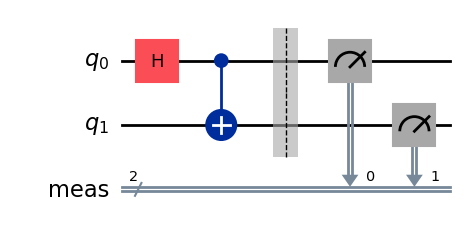

In [3]:
from qiskit import QuantumCircuit, transpile

# create a Bell circuit
bell_meas = QuantumCircuit(2)
bell_meas.h(0)
bell_meas.cx(0, 1)
bell_meas.measure_all()
display(bell_meas.draw("mpl"))

# Transpile to an ISA Circuit for the intended backend
isa_bell_meas = transpile(bell_meas, backend)

# Construct pub and run
pub_bell_meas = (isa_bell_meas, )

In [5]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Initialize a sampler for the backend and run
sampler = Sampler(backend)
job_bell_meas = sampler.run([pub_bell_meas], shots=10)

print(job_bell_meas.job_id())

In [6]:
from qiskit.providers.job import JobV1

# Extract results
job_bell_meas = service.job("cth2x8n5q9w0008g81wg")

result_bell_meas = job_bell_meas.result()
data_bell_meas = result_bell_meas[0].data
data_bell_meas

/opt/miniconda3/envs/QGSS2024/lib/python3.12/site-packages/qiskit/qpy/interface.py:305: UserWarning: The qiskit version used to generate the provided QPY file, 1.1.1, is newer than the current qiskit version 1.1.0. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


DataBin(meas=BitArray(<shape=(), num_shots=10, num_bits=2>))

In [7]:
bits = data_bell_meas.meas
print("shape:", bits.shape)
print("num_bits:", bits.num_bits)
print("num_shots:", bits.num_shots)
print("array:\n", bits.array)

shape: ()
num_bits: 2
num_shots: 10
array:
 [[3]
 [3]
 [0]
 [0]
 [0]
 [0]
 [0]
 [3]
 [3]
 [1]]


In [8]:
bitstrings = bits.get_bitstrings()
print(bitstrings)

['11', '11', '00', '00', '00', '00', '00', '11', '11', '01']


In [9]:
counts = bits.get_counts()
print(counts)

{'11': 4, '00': 5, '01': 1}


### Parametric Example 
*Control 2-qubit entanglement via parameter*

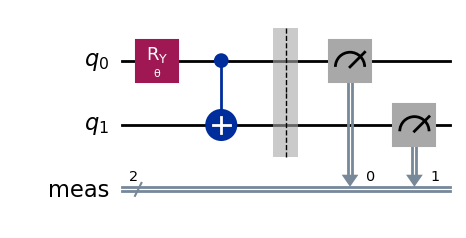

In [10]:
import numpy as np
from qiskit.circuit import Parameter

# parameterized circuit
theta = Parameter("θ")

par_bell_meas = QuantumCircuit(2)
par_bell_meas.ry(theta, 0)
par_bell_meas.cx(0, 1)
par_bell_meas.measure_all()
display(par_bell_meas.draw("mpl"))

# Parameter values to evaluate with 20 theta values
param_vals = np.linspace(0, np.pi, 20)

# Transpile to an ISA Circuit for the intended backend
isa_par_bell_meas = transpile(par_bell_meas, backend)


# Construct pub and run
# Pub and result shape is (20,)
pub_par_bell_meas = (isa_par_bell_meas, param_vals)
job_par_bell_meas = sampler.run([pub_par_bell_meas], shots=1000)

In [11]:

job_par_bell_meas = service.job("cthe4zv907y0008vhk00")
result_par_bell_meas = job_par_bell_meas.result()

# Extract result data
bits = result_par_bell_meas[0].data.meas
bits

/opt/miniconda3/envs/QGSS2024/lib/python3.12/site-packages/qiskit/qpy/interface.py:305: UserWarning: The qiskit version used to generate the provided QPY file, 1.1.1, is newer than the current qiskit version 1.1.0. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


BitArray(<shape=(20,), num_shots=1000, num_bits=2>)

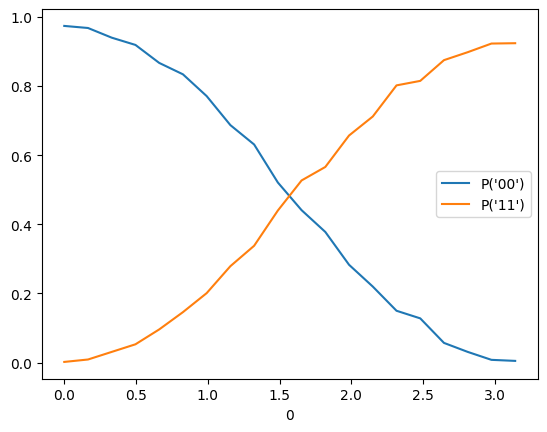

In [12]:
import matplotlib.pyplot as plt
import seaborn # type: ignore

# Compute the probability of "00" outcome and "11" outcome
p0s = np.sum(bits.array == 0, axis=1) / bits.num_shots
p1s = np.sum(bits.array == 3, axis=1) / bits.num_shots

plt.plot(param_vals, p0s, label="P('00')")
plt.plot(param_vals, p1s, label="P('11')")
plt.xlabel("0")
plt.legend()
plt.show()

### *About Shots*

shot이라는 option은 pub에서도, Sampler에서도 지정할 수 있다.  
- Sampler의 shot은 pub내부에서 shot이 지정되지 않았을 때 적용된다.
- 두 option 모두 정의되지 않았을 때는, Qiskit에서 정해둔 default value를 이용한다.

In [ ]:
# 1. All shots in pub
pub1a = (isa_bell_meas, None, 100) 
pub1b = (isa_bell_meas, None, 100) 

result1 = sampler.run([pub1a, pub1b], shots=1000).result()

for i, res in enumerate(result1):
    print(f"Pub {i}: num_shots = {res.data.meas.num_shots}")

In [ ]:
# 2. Fall back to 'run' shots
pub2a = (isa_bell_meas,)
pub2b = (isa_bell_meas, None, 200)

result2 = sampler.run([pub2a, pub2b], shots=1000).result()

for i, res in enumerate(result2):
    print(f"Pub {i}: num_shots = {res.data.meas.num_shots}")

In [ ]:
# 3. Fall back to default shots
pub3a = (isa_bell_meas,)
pub3b = (isa_bell_meas, None, 200)

result3 = sampler.run([pub3a, pub3b]).result()

for i, res in enumerate(result3):
    print(f"Pub {i}: num_shots = {res.data.meas.num_shots}")

## Estimator primitive

Estimator primitive 방법은 기본적인 measurement가 아닌 다른 방식의 measurement를 수행할 수 있으며, measurement에 사용할 operation을 **observable**로서 지정해줄 수 있다. 

observable을 수행할 qubit의 인덱스에는 해당 operator를, observable을 수행하지 않을 qubit의 인덱스에는 아무런 연산도 하지않는 operator인 **Identity matrix**를 기입하여 Observable을 지정할 수 있다.

실행결과로 observable의 expectation value, std를 반환하기 때문에 더 higher level의 execution이다.


대표적인 특징을 정리하면 다음과같다.
- high-level execution
- observable의 expectation value, std를 반환한다.
- circuit자체에 measurement가 없어야한다.

### Estimator API

Estimator 클래스의 인스턴스를 생성하고, `.run()`메소드를 호출하여 Estimator primitive를 이용할 수 있다.
- pubs: `pub`들의 리스트. pub은 Primitive Unified Blocs를 의미하며, Sampler가 수행할 하나의 작업단위를 의미한다.
- precision: `pub`에 대해 작업을 수행하여 observable의 expectation value, std를 얻을 때의 정확도. (pub 내부에 precision이 정의되지 않은 경우에만 적용된다; overide 불가)

```python
Estimator.run(
    pubs: list[EstimatorPub],
    precision: float | None = None,
) -> Job[EstimatorResult]
```

`pub`은 보통 다음과 같은 **튜플** 형태로 정의된다.
- circuit: 실행할 quantum circuit. **transpile**을 진행하여 ISA circuit 형태여야한다.
- observables: quantum circuit에 대해 관측하고자하는 observables. **transpile**을 진행하여 ISA observables 형태여야한다.
- parameter_values: 특정 parameter에 의해 operator의 값이 변화하는 등의 parameterized circuit에서 사용할 parameter의 값. ND-array 형태로 전달한다.
- precision: 해당 quantum circuit에서 observable의 expectation value, std를 얻을 때의 정확도.

```python
pub = (circuit [required],
        observables [required],
        parameter_values [optional],
        precision [optional],)
```

### Example

In [13]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit import QuantumCircuit, transpile

# Create a Bell circuit
bell = QuantumCircuit(2) 
bell.h(0)
bell.cx(0, 1)
bell.draw("mpl")

# Transpile to an ISA Circuit for the intended backend 
isa_bell = transpile(bell, backend)

In [14]:
import qiskit.quantum_info as qi

# Create an observable
obs = qi.SparsePauliOp(["ZZ"]) 

# Transpile to ISA observable for intended ISA circuit 
isa_obs = obs.apply_layout(isa_bell.layout)

In [26]:
# Construct Estimator
estimator = Estimator(backend)

# Construct pub and run
pub = (isa_bell, isa_obs)
est_job_bell = estimator.run([pub])

print(est_job_bell.job_id())

cthjh14x7b5g008zseag


In [15]:
est_job_bell = service.job("cthjh14x7b5g008zseag")
est_result_bell = est_job_bell.result()

data = est_result_bell[0].data
evs = data.evs
stds = data.stds

print(f"<ZZ> = {evs:.3f} ± {stds:.3f}")

/opt/miniconda3/envs/QGSS2024/lib/python3.12/site-packages/qiskit/qpy/interface.py:305: UserWarning: The qiskit version used to generate the provided QPY file, 1.1.1, is newer than the current qiskit version 1.1.0. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


<ZZ> = 1.520 ± 0.071


### Parameteric Example: Broadcasting

Estimator 또한 parameterized circuit의 실행을 지원한다. 그러나, 1개의 measurement option만을 가지는 Sampler와 다르게 Estimator는 **여러개의 observable**을 사용할 수 있기 때문에, Broadcasting이 필요하다.

Broadcasting은 다음 형태로 진행된다.  

![fig|center|300](https://i.imgur.com/V7KbPxJ.png)

In [16]:
# Parameterized vell circuit
theta = Parameter("θ")

par_bell = QuantumCircuit(2)
par_bell.ry(theta, 0)
par_bell.cx(0, 1)
par_bell.draw("mpl")

# Transpile to an ISA Circuit for the intended backend 
isa_par_bell = transpile(par_bell, backend)

# Parameter values to evaluate with 20 theta values 
param_vals = np.linspace(0, np.pi, 20)

# Create an observable array with 3 observables
par_bell_obs = [ 
    qi.SparsePauliOp(["XX"]),
    qi.SparsePauliOp(["YY"]),
    qi.SparsePauliOp(["ZZ"]),
]

# Transpile to ISA observable and reshape to (3, 1) array
isa_par_bell_obs = [ 
    [op.apply_layout(isa_par_bell.layout)]
    for op in par_bell_obs
]

# Construct pub and run
# Pub and result shape is (20,)
pub = (isa_par_bell, isa_par_bell_obs, param_vals)

In [18]:
# Run estimator
estimator = Estimator(backend)

est_job_par_bell = estimator.run([pub])
print(est_job_par_bell.job_id())

cthkmp24gjh0008nrf90


In [20]:
est_job_par_bell = service.job("cthkmp24gjh0008nrf90")
est_result_par_bell = est_job_par_bell.result()
evs = est_result_par_bell[0].data.evs 
stds = est_result_par_bell[0].data.stds

print(evs)
print(stds)

[[ 0.01336898  0.17005348  0.33850267  0.48342246  0.60374332  0.75187166
   0.84759358  0.92887701  0.96417112  0.99786096  1.00213904  0.97807487
   0.92032086  0.82834225  0.7315508   0.63368984  0.49251337  0.32299465
   0.17860963 -0.02727273]
 [-0.02192513 -0.1513369  -0.31657754 -0.47754011 -0.63636364 -0.75294118
  -0.82727273 -0.92941176 -0.95935829 -1.00695187 -0.99786096 -0.95882353
  -0.9197861  -0.85454545 -0.71764706 -0.62406417 -0.4802139  -0.34224599
  -0.16363636  0.00641711]
 [ 1.00641711  1.0026738   1.00909091  1.01336898  1.00160428  1.00320856
   1.01657754  1.00748663  1.0026738   1.01871658  1.00855615  1.01069519
   1.02352941  1.0171123   1.01122995  1.00695187  1.00748663  0.99786096
   1.00748663  0.99625668]]
[[0.02218787 0.0191151  0.01559526 0.01808389 0.01301778 0.01609954
  0.01441482 0.01297033 0.01398356 0.0123337  0.01272079 0.01154361
  0.01287753 0.01465839 0.01288137 0.0144851  0.01493569 0.01550826
  0.01825041 0.01709535]
 [0.01684817 0.01244988

### Observables

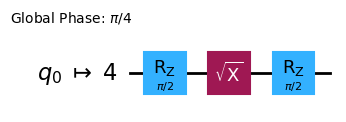

In [21]:
abstract_example = QuantumCircuit(1) 
abstract_example.h(0)

isa_example = transpile(
    abstract_example, backend, initial_layout=[4]
)
display(isa_example.draw('mpl', idle_wires=False))

In [22]:
abstract_obs = qi.SparsePauliOp(["X", "Y", "Z"]) 
abstract_obs.apply_layout(isa_example.layout)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j])

#### Containters

Observable이나 parameter등을 더 쉽게 다루기 위한 자료형이 존재한다.

In [26]:
from qiskit.primitives.containers.observables_array import (
    ObservablesArray
)

# Shape (3, 1) list of Pauli array
obs = ObservablesArray(["XX", "YY", "ZZ"]).reshape(3,1)

# Apply ISA circuit layout
isa_obs = obs.apply_layout(isa_par_bell.layout)

#! Theses classes are experimental. in version 1.1.0 not enable.

AttributeError: 'ObservablesArray' object has no attribute 'apply_layout'

In [24]:
from qiskit.primitives.containers.bindings_array import (
    BindingsArray
)

BindingsArray({tuple(isa_par_bell.parameters): param_vals})

BindingsArray(<shape=(20,), num_parameters=1, parameters=['θ']>)

#### PauliList Grouping 
Grouping하여 수행하면, 동일한 qubit에 적용되지 않는 operator 등을 한번에 묶어서 처리함으로서 observable을 measuerment하는 것을 최적화한다. 

In [25]:
paulis = qi.PauliList([
    "ZII", "ZII", "IIZ",
    "XII", "IXI", "IIX", 
    "YII", "IYI", "IIY"]
)

paulis.group_commuting(qubit_wise=True)

[PauliList(['XII', 'IIZ', 'IXI']),
 PauliList(['YII', 'IIX', 'IYI']),
 PauliList(['ZII', 'ZII', 'IIY'])]

#### Custom Observables and decomposing

Pauli operator들의 linear combination으로 만들어지는 새로운 Hamiltonian을 사용하여 observable을 정의할 수 있다.
$$H = \sum_i \alpha_i P_i$$

이때 *{CUSTOM_OBS}.paulis를 이용하면 그 operator를 구성하는 pauli operator들을 얻을 수 있다.  
따라서 아레 예시 코드의 obs는 총 4개의 observable을 가진다.

In [27]:
# Want to estimate expval of
H = qi.SparsePauliOp(["ZII", "IZI", "IIZ"], 1/3)

# To get access to component terms as well we should set 
obs = ObservablesArray([H, *H.paulis])
obs

ObservablesArray([{'ZII': np.float64(0.3333333333333333), 'IZI': np.float64(0.3333333333333333), 'IIZ': np.float64(0.3333333333333333)}
                  {'ZII': 1} {'IZI': 1} {'IIZ': 1}], shape=(4,))

### Twirling
*Pauli twirling converts a general noise channel into a Pauli error channel.*

In [28]:
# Method1: Set options after initializing
twirl_sampler = Sampler(backend)
twirl_sampler.options.twirling.enable_gates = True
twirl_sampler.options.twirling.enable_measure = True
twirl_sampler.options.twirling.strategy = "active-circuit"

# Method2: Pass-options during initialization
options = {
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "strategy": "active-circuit",
    },
}
twirl_sampler = Sampler(backend, options = options)

### Resilience Levels
*The runtime Estimator has built in resilience levels to automate option configuration*

-> resilience_level 값이 높을 수록 더 정확한 결과를 얻을 수 있지만, 시간이 오래걸린다.

In [29]:
# Initialize estimator for ZNE
estimator = Estimator(
backend, options={"resilience_level": 2})

# Initialize and *Customize* an estimator for ZNE 
estimator = Estimator(backend) 
estimator.options.resilience_level = 2
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XY4"
estimator.options.resilience.zne.extrapolator = "linear"